<a href="https://cognitiveclass.ai"><img src = "https://imagenes.20minutos.es/files/article_amp/uploads/imagenes/2021/01/28/corruption-2727571-1280-1.png" width = 400> </a>

<h1 align=center><font size = 6>Fake news detection through Machine Learning</font></h1>

## Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#1)<br>
2. [Data adquisition and cleaning](#2)<br>
    1. [Data Cleaning](#21)
    2. [Data Wrangling / Preprocessing](#22)
    3. [Feature Selection](#23)
    4. [Final Dataframe](#24)
3. [Exploratory data Analysis (EDA)](#3) <br>
    1. [Descriptive Statistical Analysis](#31)
    2. [Correlation and Causation](#32)
    3. [Word Cloud](#33)
4. [Text Representation](#4) <br>
    1. [TF-IDF](#41)
    2. [Documet Embedding](#42)
6. [Model Development](#5) <br>
    1. [Logistic Regresssion](#51)
    2. [Neural Networks](#52)
7. [Results](#7) <br>
8. [Conclusion](#8) <br> 
</div>
<hr>

## Introduction <a id="1"></a>

Como se menciona en el titulo, vamos a diseñar un modelo de predicción orientado a la detección de noticias falsas. Para esta tarea emplearemos dos formas diferentes de representar palabras y utilizaremos dos modelos logísticos diferentes. A diferencia de proyectos anteriores, vamos a trabajar con dos features que son de tipo texto, añadiendo asi algo de complejidad extra al proyecto.

Nuestro objetivo será comparar resultados entre representaciones diferentes y obtener un clasificador que realice de forma correcta la clasificación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import regex as re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import metrics
from gensim import models
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns
from sklearn import preprocessing
import pickle
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from wordcloud import WordCloud

<hr>

## 2. Data adquisition and cleaning<a id="2"></a>

Primero de todo, obtendremos el conjunto de datos.

In [2]:
df_fake = pd.read_csv('./Data/Fake.csv')
df_real = pd.read_csv('./Data/True.csv')

Como se observa, los datos estan divididos en dos conjuntos de datos dependiendo de la clase, es por ello que vamos a unirlos para poder trabajar con mas comodidad.

In [3]:
df_fake["label"] = "fake"
df_real["label"] = "real"
df_news = pd.concat([df_fake,df_real]).sample(frac=1)
df_news.reset_index(drop=True, inplace=True)

In [4]:
df_news

,title,text,subject,date,label
0,Cameroon court sentences opposition leader to ...,"DOUALA, Cameroon (Reuters) - A military court ...",worldnews,"October 30, 2017",real
1,Trump Calls For This Racist Policy To Be Forc...,Donald Trump is calling for one of the most co...,News,"September 21, 2016",fake
2,Liberia to hold run-off vote on December 26: e...,MONROVIA (Reuters) - Liberia will hold a delay...,worldnews,"December 12, 2017",real
3,MSNBC’S LAWRENCE O’DONNELL: This Could Be the ...,MSNBC s Lawrence O Donnell was really reaching...,politics,"Jun 5, 2017",fake
4,WATCH: FRATERNITY BROTHERS BUILD “Make America...,Many Americans believe it s racist to keep m...,politics,"Apr 14, 2016",fake
...,...,...,...,...,...
44893,Facebook Now Decides What Is Branded Fake News,21st Century Wire says Facebook knows best?Fac...,US_News,"March 6, 2017",fake
44894,Boiler Room EP #69 – CULTure Club,Tune in to the Alternate Current Radio Network...,Middle-east,"August 18, 2016",fake
44895,Swiss urge voters to keep fee for public broad...,ZURICH (Reuters) - The Swiss government urged ...,worldnews,"December 11, 2017",real
44896,Flint’s #CrookedMayorWeaver Tells Trump He’s N...,Flint s Democrat Mayor Karen Weaver is throwin...,left-news,"Sep 14, 2016",fake


### 2.1 Data Cleaning<a id="21"></a>
Es importante mantener solo los features que más nos interesan, es por ello que vamos a eliminar todo lo que no este relacionado con el texto. Ya que la naturaleza de esta tarea es la clasificación mediante el texto. Del mismo modo, tenemos que eliminar los atributos que tengan muchos valores nulos.

<AxesSubplot:>

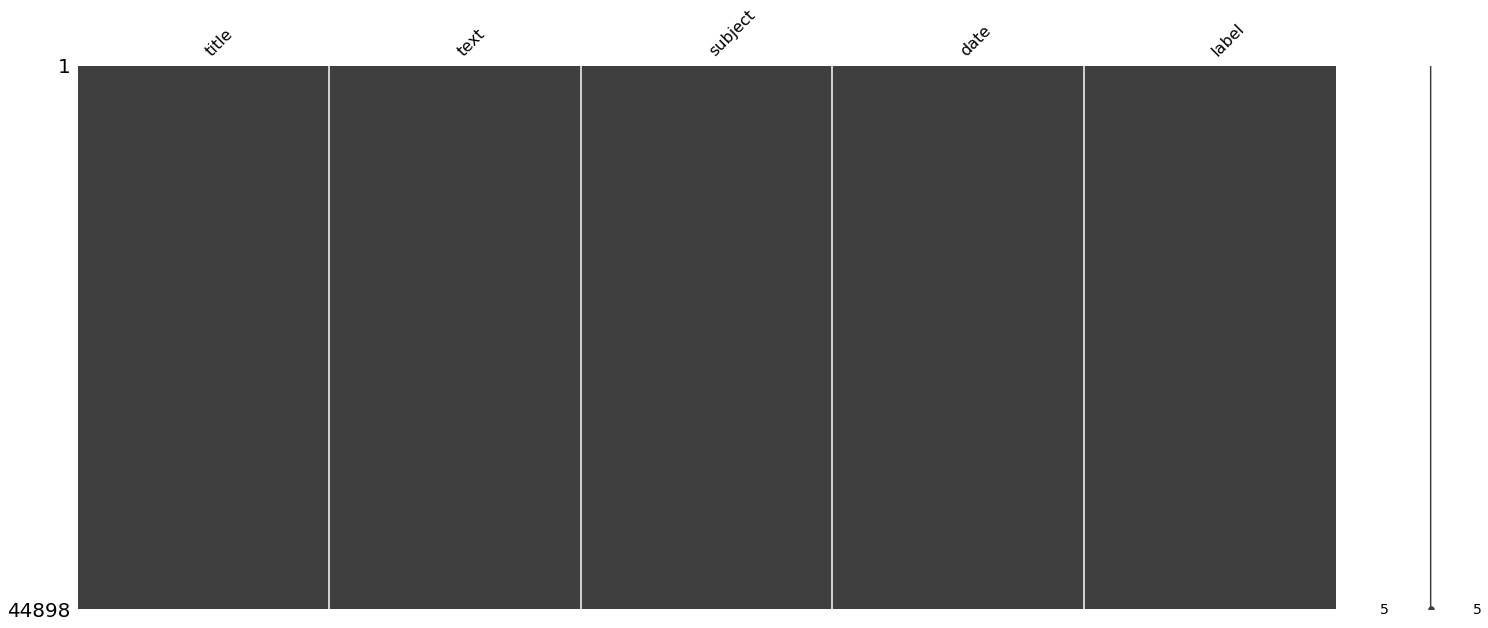

In [5]:
msno.matrix(df_news)

Como podemos observar, no encontramos valores nulos, es por ello que no es necesario eliminar columnas por falta de valores.

###  2.2 Data Wrangling / Preprocessing<a id="22"></a>
El data Wrangling es el proceso de transformar y mappear los datos a un formato estandar. En nuestro caso, al estar trabajando con texto, intentaremos normalizar los datos intentando perder la menor cantidad de información.
Para ello es posible que generemos nuevas columnas a partir de la información extraida en el texto. Esta parte corresponde una parte importante del trabajo.,

In [6]:
df_news

,title,text,subject,date,label
0,Cameroon court sentences opposition leader to ...,"DOUALA, Cameroon (Reuters) - A military court ...",worldnews,"October 30, 2017",real
1,Trump Calls For This Racist Policy To Be Forc...,Donald Trump is calling for one of the most co...,News,"September 21, 2016",fake
2,Liberia to hold run-off vote on December 26: e...,MONROVIA (Reuters) - Liberia will hold a delay...,worldnews,"December 12, 2017",real
3,MSNBC’S LAWRENCE O’DONNELL: This Could Be the ...,MSNBC s Lawrence O Donnell was really reaching...,politics,"Jun 5, 2017",fake
4,WATCH: FRATERNITY BROTHERS BUILD “Make America...,Many Americans believe it s racist to keep m...,politics,"Apr 14, 2016",fake
...,...,...,...,...,...
44893,Facebook Now Decides What Is Branded Fake News,21st Century Wire says Facebook knows best?Fac...,US_News,"March 6, 2017",fake
44894,Boiler Room EP #69 – CULTure Club,Tune in to the Alternate Current Radio Network...,Middle-east,"August 18, 2016",fake
44895,Swiss urge voters to keep fee for public broad...,ZURICH (Reuters) - The Swiss government urged ...,worldnews,"December 11, 2017",real
44896,Flint’s #CrookedMayorWeaver Tells Trump He’s N...,Flint s Democrat Mayor Karen Weaver is throwin...,left-news,"Sep 14, 2016",fake


In [7]:
df_fake["text"][3]

'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

In [8]:
df_real["text"][3]

'WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based inte

Despues de visualizar varias instancias de diferente clase, se han observado diferencias:
1. **Longitud:** Las noticias reales tienden a ser más largas.
2. **Menciones:** Las noticias falsas tienden a tener @ de twitter, lo cual hace que no sea una fuente muy fiable.
3. **URL:** Las noticias falsas tienden a tener mas URL que las verdaderas.

### 1. Longitud en base a la clase

In [9]:
def count_word_number(phrase):
    return len(phrase.split())

In [10]:
# Añadir una columna con la longitud de la frase.
df_fake['len'] = df_fake.apply(lambda row : count_word_number(row['text']), axis = 1)
df_real['len'] = df_real.apply(lambda row : count_word_number(row['text']), axis = 1)

<BarContainer object of 2 artists>

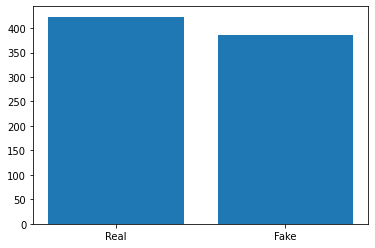

In [11]:
plt.bar(["Real","Fake"], [df_fake['len'].mean(),df_real['len'].mean()])

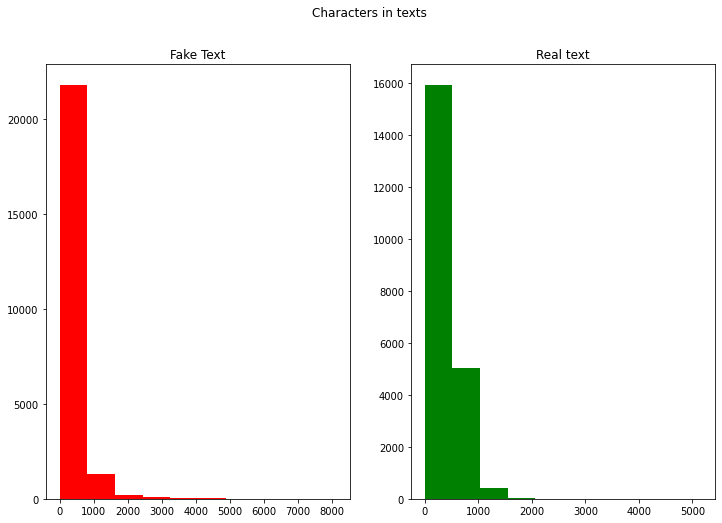

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df_fake['len'],color='red')
ax1.set_title('Fake Text')
ax2.hist(df_real["len"],color='green')
ax2.set_title('Real text')
fig.suptitle('Characters in texts')
plt.show()

### 2. Menciones

Como hemos mencionado anteriormente, es muy común utilizar menciones en redes sociales, es por ello que las noticias extraidas directamente de estas tienden a ser falsas.

In [13]:
def count_twitters_user(df):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(twitter_username_re, text))
    return count

<BarContainer object of 2 artists>

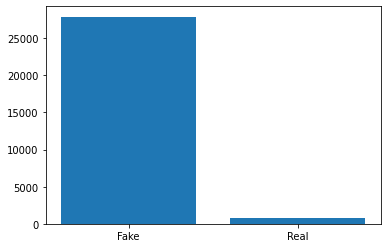

In [14]:
plt.bar(["Fake","Real"],[count_twitters_user(df_fake),count_twitters_user(df_real)])

Como se puede observar, existe una clara correlación entre la clase y la cantidad de menciones que se realizan en una noticia. Para analizar la corelación, vamos a usar Analysis of Variance (ANOVA)

### 3. URL

In [15]:
def count_url(df):
    url_re = re.compile(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(url_re, text))
    return count

def count_mention_text(text):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = len(re.findall(twitter_username_re, text))
    return count

<BarContainer object of 2 artists>

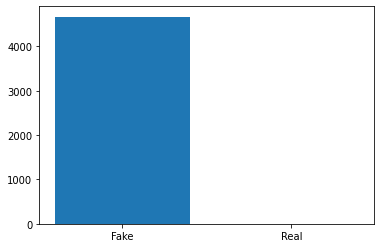

In [16]:
plt.bar(["Fake","Real"],[count_url(df_fake),count_url(df_real)])

## Adaptación de los datos<a name="moldaketa"></a>
### Hemos dividido el preprocessing en diez pasos diferentes:
1. Borrar las URL
2. Pasar todo a minúsculas
3. Quitar los stopwords
4. Quitar las marcas de puntuacion
5. Corregir palabras
6. Lemmanization
7. Corregir palabras

### 1.Borrar las URL
En las noticias podemos encontrar URL-s las cuales no no son de utilidad. Es por ello que vamos a eliminarlas. Del mismo modo, sabemos que las URL son indicadores de la veracidad de la noticia, es por ello que este valor vamos a guardarlo en una columna aparte.

In [18]:
df_preprocessed = pd.read_csv("./Data/news.csv")

In [21]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [20]:
df_preprocessed

,title,text,label,has_mentions
0,Palestinian gunman kills three Israeli guards ...,"HAR ADAR, West Bank (Reuters) - A Palestinian ...",real,False
1,3 CONSERVATIVE CELEBRITIES Visited Trump Last ...,"Ted Nugent is all smiles, as he s pictured wit...",fake,False
2,Bone fragments found in Mexico to be tested fo...,MEXICO CITY (Reuters) - Mexican authorities sa...,real,False
3,Republicans Now Trying To Draft Billionaire M...,A group of desperate republicans which include...,fake,False
4,Trump’s Idiot Press Secretary Tweeted Out His...,When President Asterisk assured us he was asse...,fake,True
...,...,...,...,...
44893,FERGUSON FLAMETHROWER COMES OUT OF HIDING: Sla...,Holder should be making his baseless remarks f...,fake,False
44894,Street Performer Will Let You Punch ‘Donald T...,A street performer based in New York City is g...,fake,True
44895,Hungary not planning to move Israeli embassy t...,BUDAPEST (Reuters) - Hungary is not planning t...,real,False
44896,Poland ready to defend migration stance in EU ...,WARSAW (Reuters) - Poland is ready to defend i...,real,False


In [22]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: remove_urls(text))

In [23]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: remove_urls(text))

### 2. Pasar todo a minusculas

Para que sea mas sencillo el procesamiento del texto, vamos a trasnformar todas las frases a minusculas.

In [24]:
df_preprocessed["title"] = df_preprocessed["title"].str.lower()

In [25]:
df_preprocessed["text"] = df_preprocessed["text"].str.lower()

### 3. Quitar los stopwords

Las conocidas como "palabras vacias" son aquellas que no nos van a aportar ninguna información, es por ello que vamos a eliminaras.


In [28]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

In [29]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: remove_stopwords(text))

In [30]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: remove_stopwords(text))

### 4. Quitar las marcas de puntuacion

Las marcas de puntuación no son relevantes, por tanto vamos a eliminarlo.

In [43]:
import string
def remove_punctuation(text:str):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    PUNCT_TO_REMOVE += 'â’'
    spaces = ''
    for i in range(len(PUNCT_TO_REMOVE)):
        spaces += ' '
    return text.translate(str.maketrans(PUNCT_TO_REMOVE, spaces))
# ---- #


In [44]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: remove_punctuation(text))

In [45]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: remove_punctuation(text))

### 5. Corregir palabras

In [ ]:
df_preprocessed['title'] = df_preprocessed['title'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [ ]:
df_preprocessed['text'] = df_preprocessed['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [48]:
df_preprocessed.to_csv("preprocessed_backup.csv",index=False)

In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

### 6. Lemmanization
En este proceso, lemmanizamos las palabras, lo cual trata de eliminar las posibles conjugaciones. Mas información en el siguiente link: https://en.wikipedia.org/wiki/Lemmatisation

In [52]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [56]:
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: lemmatize_words(text))

In [57]:
df_preprocessed["title"] = df_preprocessed["title"].apply(lambda text: lemmatize_words(text))

### 7. Corregir palabras

Es posible que despues de todo este proceso, algunas palabras se hayan "corrompido", es por eso que vamos a volver a corregirlas.

In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
df['OriginalTweet'] = df['OriginalTweet'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

### 2.3 Feature Selection<a id="23"></a>
En este apartado vamos a seleccionar los atributos que nos interesan para nuestro conjunto de datos.


In [18]:
df_news.drop(["subject","date"],axis=1,inplace=True)

Primero eliminaremos estas dos columnas originales del conjunto de datos, ya que no nos interesan para la tarea a realizar.

Por otro lado, hemos observado de forma superficial la correlación entre la clase y la cantidad de menciones, es por ello que vamos añadirlo al conjunto de datos. Este atributo es valido debido a que está extraido directamente del texto.

In [19]:
df_news['has_mentions'] = df_news.apply(lambda row : count_mention_text(row['text'])>1, axis = 1)

### 2.4 Final Dataframe <a id="24"></a>

In [20]:
df_news.to_csv("./Data/news.csv",index=False)

<hr>

## Exploratory data Analysis (EDA) <a id="3">
    
En este apartado analizaremos los datos y sacaramos información que nos será de relevancia. Para ello usaremos el conjunto de datos que no hemos preprocesado.

In [21]:
df = pd.read_csv("./Data/news.csv")

In [22]:
df.loc[(df.label == 'real'),'label']=1  
df.loc[(df.label == 'fake'),'label']=0
df.loc[(df.has_mentions == 'True'),'has_mentions']=1  
df.loc[(df.has_mentions == 'False'),'has_mentions']=0

De este modo damos un valor numerico a la clase a predecir, lo cambiaremos mas adelante, pero por ahora lo tendremos como numerico para las métricas.

### Descriptive Statistical Analysis<a id="31">

### Correlation and Causation<a id="32">

In [23]:
df

,title,text,label,has_mentions
0,Palestinian gunman kills three Israeli guards ...,"HAR ADAR, West Bank (Reuters) - A Palestinian ...",1,False
1,3 CONSERVATIVE CELEBRITIES Visited Trump Last ...,"Ted Nugent is all smiles, as he s pictured wit...",0,False
2,Bone fragments found in Mexico to be tested fo...,MEXICO CITY (Reuters) - Mexican authorities sa...,1,False
3,Republicans Now Trying To Draft Billionaire M...,A group of desperate republicans which include...,0,False
4,Trump’s Idiot Press Secretary Tweeted Out His...,When President Asterisk assured us he was asse...,0,True
...,...,...,...,...
44893,FERGUSON FLAMETHROWER COMES OUT OF HIDING: Sla...,Holder should be making his baseless remarks f...,0,False
44894,Street Performer Will Let You Punch ‘Donald T...,A street performer based in New York City is g...,0,True
44895,Hungary not planning to move Israeli embassy t...,BUDAPEST (Reuters) - Hungary is not planning t...,1,False
44896,Poland ready to defend migration stance in EU ...,WARSAW (Reuters) - Poland is ready to defend i...,1,False


In [24]:
df['label']=np.float64(df['label'])
df['has_mentions']=np.fl oat64(df['has_mentions'])
df['has_mentions'].corr(df['label'])

-0.26349296331848926

De este modo comprobamos que nuestra suposición no era la mas correcta, ya que no hay una clara correspondencia entre estos dos atributos.

### Word Cloud<a id="33">

(-0.5, 1799.5, 1399.5, -0.5)

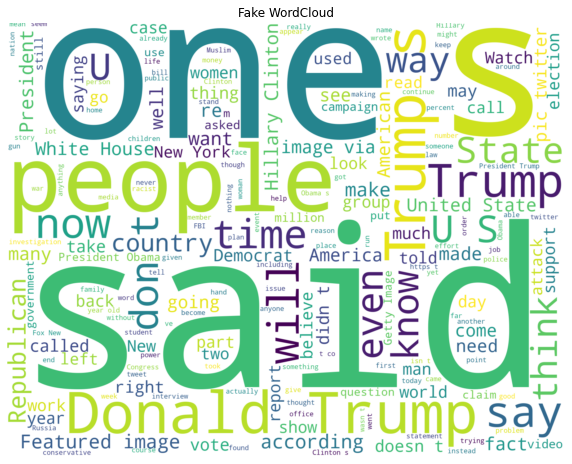

In [5]:
wc_fake = WordCloud(background_color='white',width=1800,height=1400).generate(' '.join(df_fake['text']))
plt.figure(figsize=(10,8))
plt.imshow(wc_fake, interpolation='bilinear')
plt.title("Fake WordCloud")
plt.axis("off")

(-0.5, 1799.5, 1399.5, -0.5)

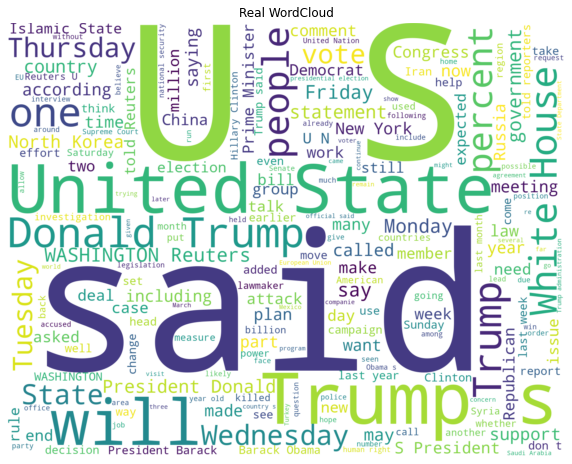

In [6]:
wc_real = WordCloud(background_color='white',width=1800,height=1400).generate(' '.join(df_real['text']))
plt.figure(figsize=(10,8))
plt.imshow(wc_real, interpolation='bilinear')
plt.title("Real WordCloud")
plt.axis("off")

<hr>

# Text Representation <a id="4">

Primero de todo, prepararemos el conjunto de datos para poder realizar la vectorización de forma adecuada, preprocesando y limpiando el texto.

## TF-IDF <a id="41">

In [29]:
df = pd.read_csv("./Data/preprocessed.csv")
df.dropna(inplace=True) 
df['text'] = df['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [30]:
df.drop("title",axis=1,inplace=True)

In [31]:
text_data = np.array(df["text"])
print(len(text_data))
vectorizer = TfidfVectorizer(min_df = 200,stop_words='english') 
train_bow = vectorizer.fit_transform(text_data)
print("Tamaño de los datos depues de aplicar TF-IDF : ",train_bow.shape) #Modu honetan badakigu zenbat atributu ditugu.

44183
Tamaño de los datos depues de aplicar TF-IDF :  (44183, 4861)


In [42]:
df_tf = pd.DataFrame(train_bow.todense(), columns=vectorizer.get_feature_names())
df_tf["label"] = df["label"] 
df.dropna(inplace=True) 

In [43]:
df_tf.to_csv("./Data/df_tf.csv",index=False)

## Document Embedding <a id="42">

In [115]:
df = pd.read_csv("./Data/preprocessed.csv")
df.dropna(inplace=True) 
df['text'] = df['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [102]:
df.drop("title",axis=1,inplace=True)

In [109]:
lista = [str(i) for i in df['text'].copy().array]
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(lista)]
model = Doc2Vec(documents=tagged_data, min_count=200,vector_size = 300,workers = 5)

In [110]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model_300")
model.save(fname)
model.save("doc_2vec_model")
model = Doc2Vec.load("doc_2vec_model")  # you can continue training with the loaded model!

In [111]:
df_test = pd.DataFrame(columns=list(range(300)),index=list(range(44183)))
tagged_df = pd.Series( (v[0] for v in tagged_data))
cosas = tagged_df.apply(model.infer_vector)
for i in range(df.shape[0]):
    df_test.loc[i] = pd.Series(cosas[i])

In [122]:
df_test.to_csv("df_200d.csv",index=False)
df_emb = pd.read_csv("df_200d.csv")

In [128]:
df = pd.read_csv("./Data/preprocessed.csv")
df_emb["has_mentions"] = df["has_mentions"]
df_emb["label"] = df["label"]
df_emb.to_csv("./Data/df_200d.csv")

<hr>

# Model Development <a id="5">

## Logistic Regresssion <a id="51">

### Logistic Regression with TF-IDF

In [81]:
df_tf = pd.read_csv("./Data/df_tf.csv")
df_tf.dropna(inplace=True) 

In [87]:
X = df_tf.drop(["label"],axis=1,inplace=False)
y = np.ravel(df_tf.filter(items=['label']))

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [85]:
df_tf.shape

(43487, 4861)

#### Vamos a obtener la mejor cantidad de atributos.

In [ ]:
score = []
max_score = 0
values = []
aux = 0

for i in range(10,4500,50):
    best_features = SelectKBest(k=i)
    fit = best_features.fit(X_train,np.ravel(y_train))
    df_new = df_tf[X.columns[fit.get_support()]]
    LR = LogisticRegression(max_iter=500,solver="saga")
    cv = KFold(n_splits=5)
    yhat = cross_val_predict(LR, df_new, y,cv=cv)
    score2 = metrics.f1_score(y, yhat,average='weighted')
    if (score2>max_score):
        max_score=score2
        aux = i
        bestFeatures = df_new
    score.append(score2)
    values.append(i)
    Valor = 'i: ' + str(i) + ' -> value: ' + str(score2) 
    print(Valor)

In [98]:
m_score = 'MAX i: ' + str(aux) + ' -> MAX value: ' + str(max_score) 
print(m_score)

MAX i: 1010 -> MAX value: 0.5449932871833396


Text(0, 0.5, 'Score')

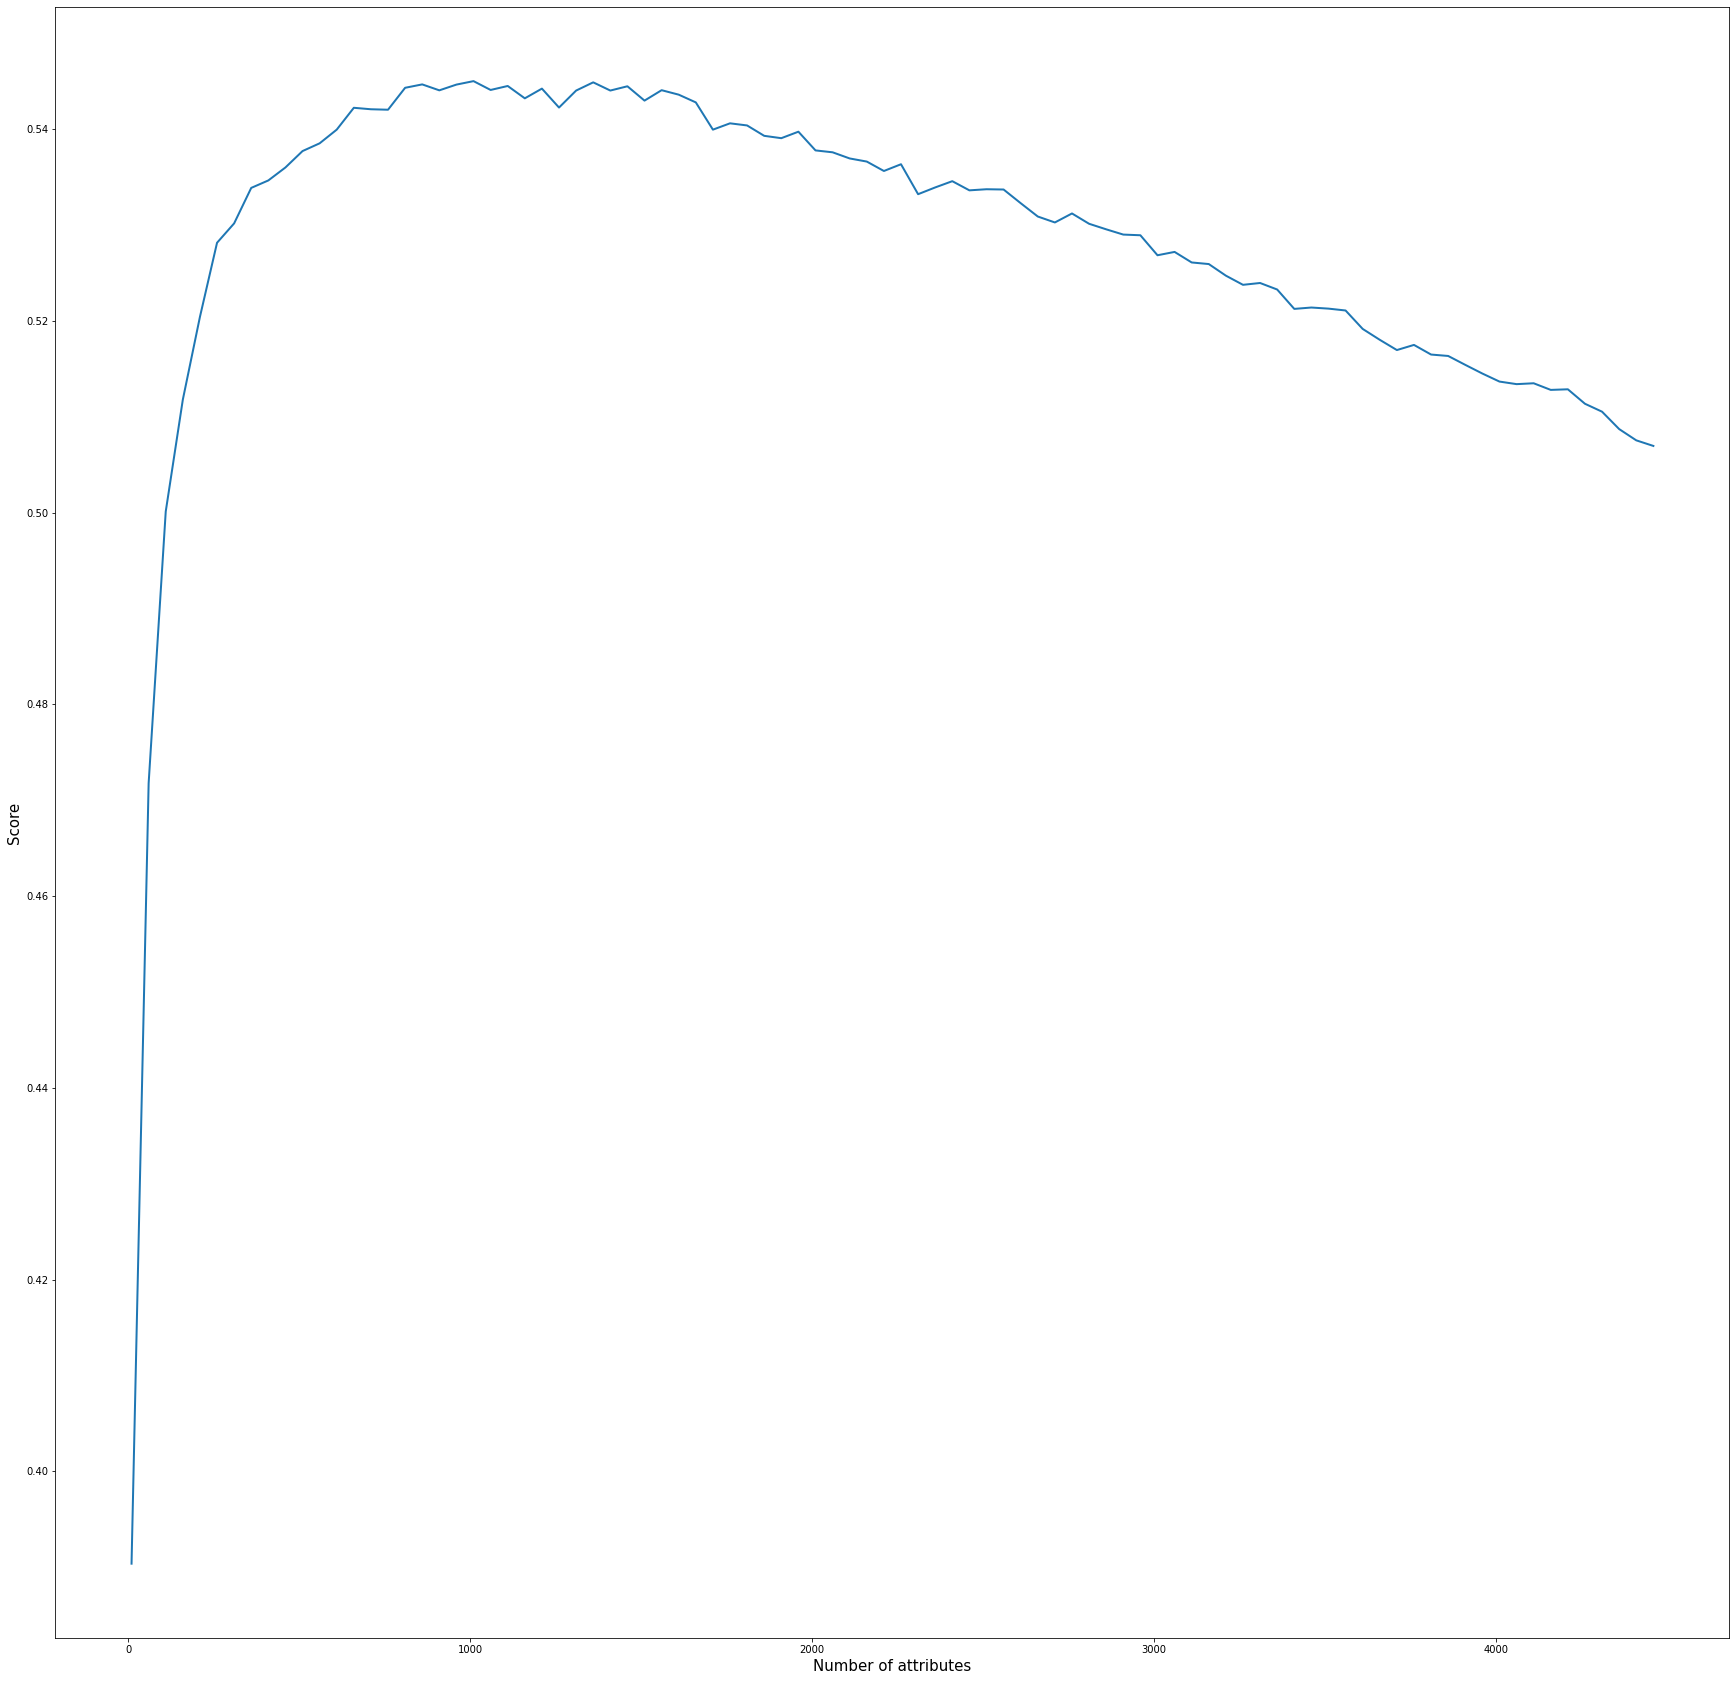

In [99]:
plt.figure(figsize=(30,30))
plt.plot(values,score, linewidth=2.0, label='fit')
plt.xlabel("Number of attributes",fontsize = 15)
plt.ylabel("Score",fontsize = 15)

In [ ]:
LR = LogisticRegression(max_iter=100,solver="saga")
cv = KFold(n_splits=5)
yhat = cross_val_predict(LR, bestFeatures, y,cv=cv)

print("Logisticc regression's R2: with ",21,metrics.f1_score(y, yhat,average='weighted'))

plt.figure(figsize=(40, 10))
sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values")

plt.title('Actual vs Predicted values for Sensitivity using Logistic Regression')
plt.xlabel('Sensitivity')
plt.ylabel('Proportion ')

plt.show()
plt.close()

In [142]:
label_encoder = preprocessing.LabelEncoder().fit(df_tf['label'])
y = label_encoder.transform(df_tf['label'])
len(y)

43487

Logisticc regression's R2: with  21 0.5450186391269264


/tartalo01/users/ksanjuan001/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/tartalo01/users/ksanjuan001/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


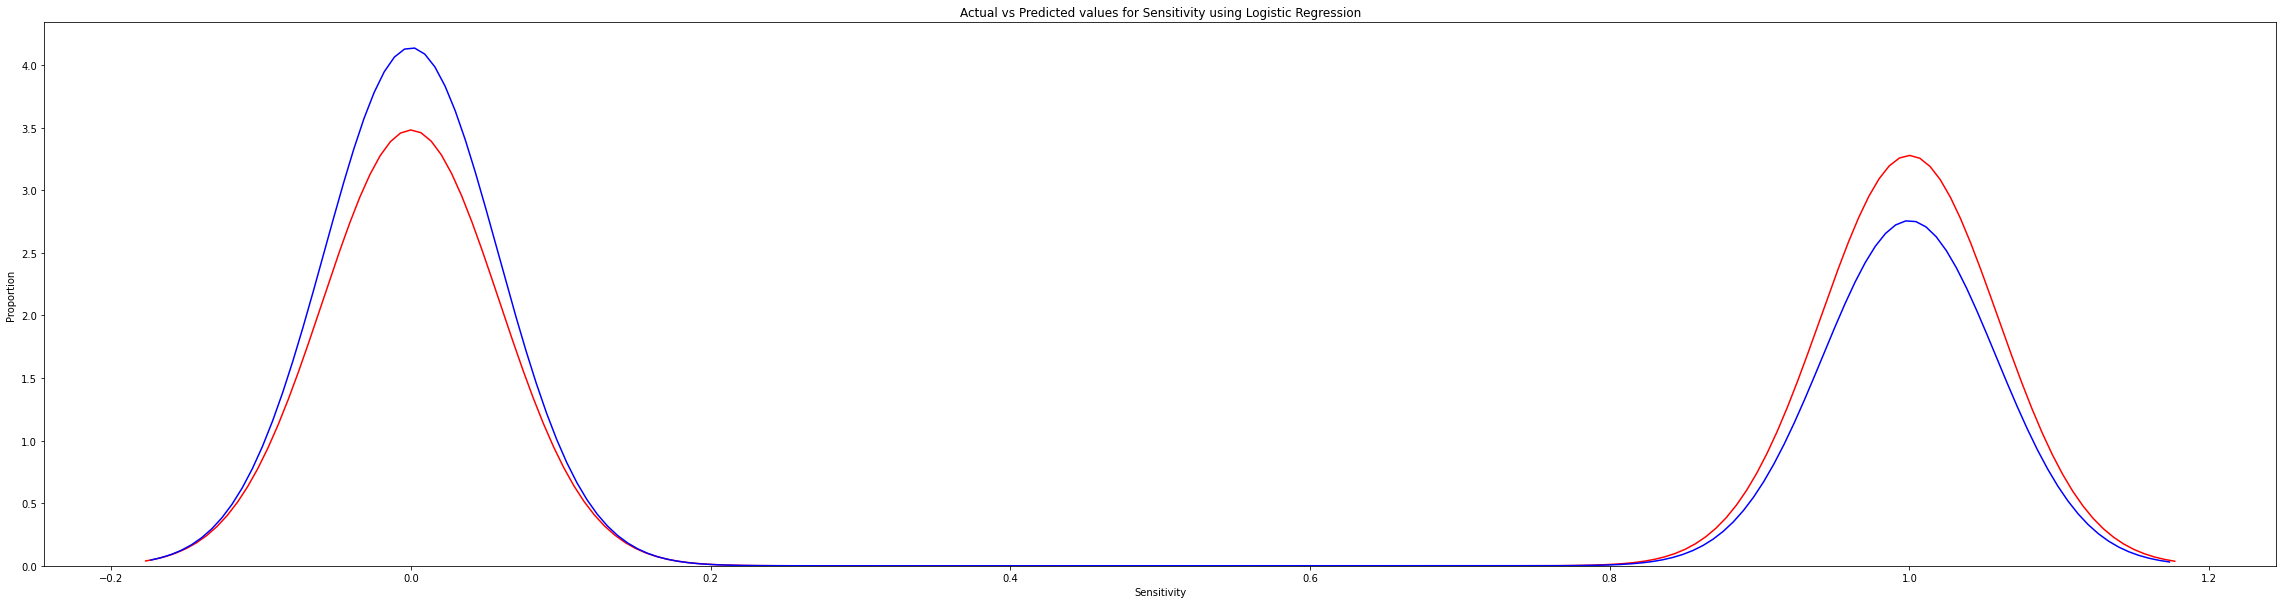

In [143]:
LR = LogisticRegression(max_iter=100,solver="saga")
cv = KFold(n_splits=5)
yhat = cross_val_predict(LR, bestFeatures, y,cv=cv)

print("Logisticc regression's R2: with ",21,metrics.f1_score(y, yhat,average='weighted'))

plt.figure(figsize=(40, 10))
sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values")

plt.title('Actual vs Predicted values for Sensitivity using Logistic Regression')
plt.xlabel('Sensitivity')
plt.ylabel('Proportion ')

plt.show()
plt.close()

### Logistic Regression with Word-Embedding

In [90]:
df_emb = pd.read_csv("./Data/df_200d.csv")

In [91]:
X = df_emb.drop("label",axis=1,inplace=False)
label_encoder = preprocessing.LabelEncoder().fit(df_emb['label'])
y = label_encoder.transform(df_emb['label'])

Logisticc regression's R2: with  21 0.535216659016656


/tartalo01/users/ksanjuan001/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/tartalo01/users/ksanjuan001/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


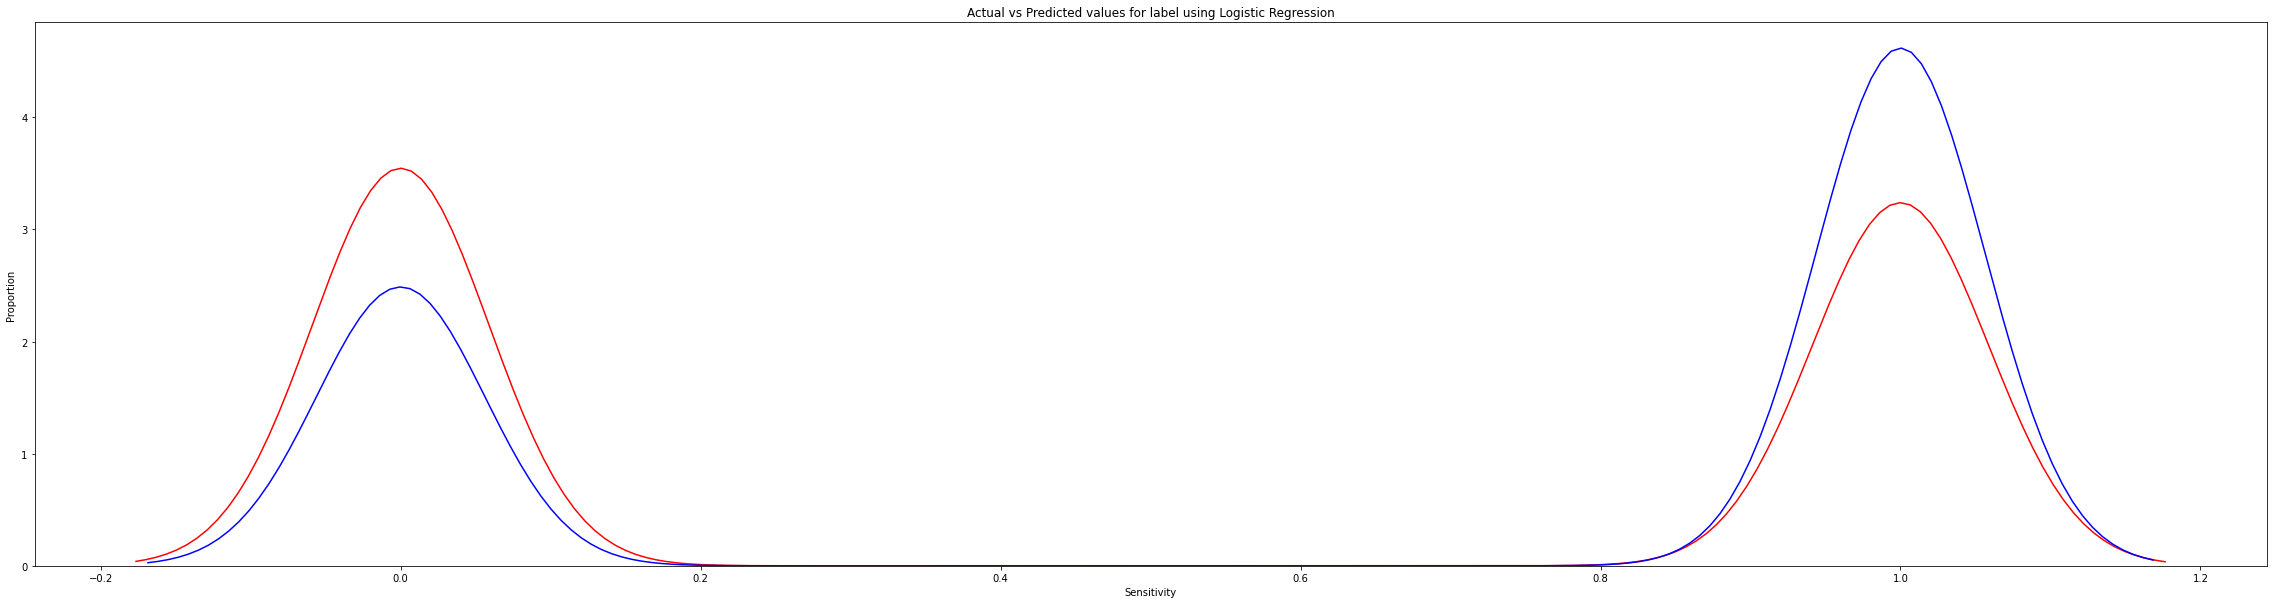

In [97]:
LR = LogisticRegression(max_iter=100,solver="saga")
cv = KFold(n_splits=5)
yhat = cross_val_predict(LR, X, y,cv=cv)

print("Logisticc regression's R2: with ",21,metrics.f1_score(y, yhat,average='weighted'))

plt.figure(figsize=(40, 10))
sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values")

plt.title('Actual vs Predicted values for label using Logistic Regression')
plt.xlabel('Sensitivity')
plt.ylabel('Proportion ')

plt.show()
plt.close()

## Neural Network <a id="52">

### Neural Network with TF-IDF

In [135]:
df_neural = pd.read_csv("./Data/df_tf.csv")
df_neural.dropna(inplace=True) 
df_neural["has_mentions"] = df["has_mentions"]
X_neural = df_neural.drop("label",axis=1,inplace=False)
label_encoder = preprocessing.LabelEncoder().fit(df_neural['label'])
y_neural = label_encoder.transform(df_neural['label'])
label_encoder = preprocessing.LabelEncoder().fit(df_neural['has_mentions'])
df_neural['has_mentions'] = label_encoder.transform(df_neural['has_mentions'])

In [136]:
best_features = SelectKBest(k=1010)
fit = best_features.fit(X_neural,np.ravel(y_neural))
df_new = df_neural[X_neural.columns[fit.get_support()]]

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
...     df_new, y_neural, test_size=0.33, random_state=42)

In [138]:
X_train.shape

(29136, 1010)

In [139]:
model = Sequential()
model.add(Dense(1011,input_dim=1010, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= "nadam",metrics=['accuracy'])

In [140]:
history = model.fit(X_train, y_train, epochs=20,batch_size=32)

Epoch 1/20
911/911 [==============================] - 7s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 2/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 3/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 4/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 5/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 6/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 7/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 8/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 9/20
911/911 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4843
Epoch 10/20
911/911 [==============================] - 4s 5ms/st

### Neural Network with Word-Embedding

In [2]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("./Data/preprocessed.csv")
df.dropna(inplace=True) 
df['text'] = df['text'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

label_encoder = preprocessing.LabelEncoder().fit(df['label'])
y = label_encoder.transform(df['label'])
X_train, X_test, y_train, y_test = train_test_split(df['text'],y, test_size=0.30, random_state=1)

In [3]:
import tensorflow 
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) 

sequences = tokenizer.texts_to_sequences(X_train)



word_index = tokenizer.word_index 
 

vocab_size = len(word_index)
print('Tamaño del vocabulario: ', vocab_size)

test_tokens = Tokenizer()
test_tokens.fit_on_texts(X_test)
test_sequences = test_tokens.texts_to_sequences(X_test)
test_word_index = test_tokens.word_index
test_vocab_size = len(test_word_index)
print('Tamaño del vocabulario del testeo: ', test_vocab_size )

Tamaño del vocabulario:  89999
Tamaño del vocabulario del testeo:  61946


In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(sequences, padding = 'post')
X_test = pad_sequences(test_sequences, padding = 'post')

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

embedding_dim=200

model = Sequential([
  Embedding(vocab_size + 1, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         18000000  
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                3216      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 18,003,233
Trainable params: 18,003,233
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=3
    )

Epoch 1/3
967/967 [==============================] - 281s 290ms/step - loss: 0.4372 - accuracy: 0.7380 - val_loss: 0.5489 - val_accuracy: 0.6561
Epoch 2/3
967/967 [==============================] - 281s 290ms/step - loss: 0.0993 - accuracy: 0.9780 - val_loss: 0.7660 - val_accuracy: 0.6201
Epoch 3/3
967/967 [==============================] - 279s 289ms/step - loss: 0.0530 - accuracy: 0.9879 - val_loss: 0.6231 - val_accuracy: 0.7316


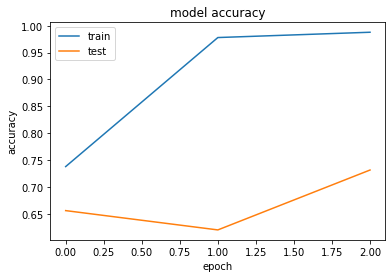

In [82]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Results <a id="6">

Como hemos podido comprobar, los resultados que ha ofrecido el word embedding han sido mejores que el TF-IDF. Además de eso, la combinación con la red neuronal es el modelo que mejor ha funcionado. Probablemente una red neuronal de otro tipo (LSTM por ejemplo) hubiera sido más apropiado. 

| Treatments | Train Score | Test Score |
|---------------------|----------------------|---------------------|
| L.Reg + TF-IDF      | 0.751                | 0.545               |
| L.Reg + Embedding   | 0.642                | 0.535               |
| NN + TF-IDF         | 0.4842               | -                   |
| NN + Embedding      | 0.97                 | 0.7316              |

# Conclusion <a id="7">
 

En conclusión podemos decir que ha sido un proyecto muy interesante, donde se ha podido trabajar con diferentes tipos de vectorización que hemos visto en clase, combinado también con modelos previamente vistos. Del mismo modo, descubrir la posibilidad de Tokenizar mediante tensorflow ha sido muy importante, el cual no dudaré en implementar en proyectos futuros.